In [1]:
from torchvision import datasets
import torch
data_folder = '/kaggle/working/' # onde o dataset importado será armazeando
fmnist = datasets.FashionMNIST(data_folder, download = True, train = True)

100%|██████████| 26421880/26421880 [00:08<00:00, 3000409.50it/s] 


Extracting /kaggle/working/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268724.99it/s]


Extracting /kaggle/working/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4957825.09it/s]


Extracting /kaggle/working/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8592231.19it/s]

Extracting /kaggle/working/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/raw



In [2]:
X = fmnist.data # conjunto previsor
Y = fmnist.targets # conjunto de classe

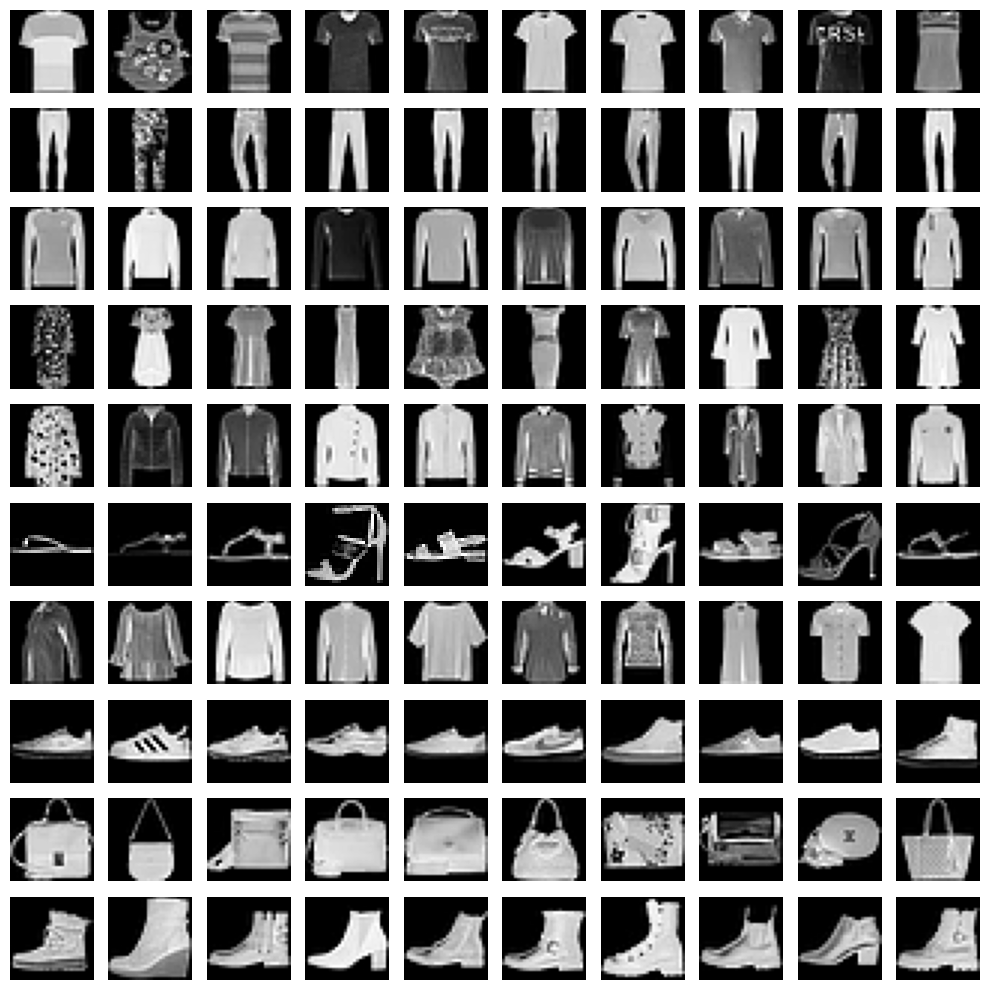

In [3]:
# visualizando algumas imagens
import matplotlib.pyplot as plt
import numpy as np

R, C = len(Y.unique()), 10 # R = número de classes; C = número de exemplos por classe
fig, ax = plt.subplots(R, C, figsize=(10, 10)) # fig = figura 10x10 polegadas; ax = array de R arrays de C eixos de subplots
for label_class, plot_row in enumerate(ax): # cada iteração retorna C subplots (plot_row) com o índice da linha (label_class), que irá corresponder à classe da linha
    label_x_rows = np.where(Y == label_class)[0] # array com os índices de Y iguais a label_class
    for plot_cell in plot_row: # itera por cada subplot no array de subplots plot_row
        plot_cell.grid(False) # remove as linhas de grid do subplot
        plot_cell.axis(False) # remove os eixos e labels do subplot
        ix = np.random.choice(label_x_rows) # escolhe um índice aletório de label_x_rows
        x = X[ix] # pega um exemplo aleatório da classe label_class
        plot_cell.imshow(x, cmap='gray') # plota o exemplo
plt.tight_layout() # ajusta os espaços entre os subplots após plotar todos

# Formatando o dataset para a rede neural do PyTorch

In [4]:
from torch.utils.data import Dataset, DataLoader # classes de criação e iteração do dataset
import torch.nn as nn # classe de construção de uma rede neural
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
class FMNISTDataset(Dataset): # classe para a construção do dataset FMNIST para pytorch
    def __init__(self, x, y):
        # x e y já vêm em formato de tensor
        x = x.float() # transforma os valores dos tensores para float32
        x = x.view(-1, 28*28) # planifica os tensores em x
        # o -1 faz com que a primeira dimensão se adapte automaticamente ao número de elementos gerado pelas outras dimensões
        self.x, self.y = x, y # adiciona as variáveis ao escopo da classe
    
    def __getitem__(self, ix): # retorna uma tupla com imagem e classe para o índice ix, armazenando-os na gpu
        return self.x[ix].to(device), self.y[ix].to(device)
    
    def __len__(self): # retorna o número de tensores no conjunto de treinamento
        return len(self.x) 
        

In [6]:
# criando o dataloader
def get_data(): # retorna um dataloader
    ds = FMNISTDataset(X, Y) # cria uma instância de FMNISTDataset com os dados de X e Y
    dl = DataLoader(ds, batch_size=32, shuffle=True) # cria um gerador para ds com batches randomizados de 32 imagens
    return dl

# Criando e treinando o modelo

In [7]:
from torch.optim import SGD
def get_model(): # retorna um modelo sequencial com SGD
    model = nn.Sequential(
        nn.Linear(28*28, 1000), # camada linear que recebe 28*28 valores e retorna 1000
        nn.ReLU(), # camada de ativação
        nn.Linear(1000, 10) # camada de saída, recebe 1000 valores e retorna 10
    ).to(device) # armazena o modelo na gpu
    loss_fn = nn.CrossEntropyLoss() # define a função de custo como a categorical cross entropy
    optimizer = SGD(model.parameters(), lr = 0.01) # cria uma instância de SGD com os parâmetros do modelo definido acima de taxa de aprendizado de 0.01
    return model, loss_fn, optimizer

In [25]:
# função de avaliação
@torch.no_grad() # desativa o cálculo de gradientes para os modelos pytorch no escopo da função abaixo
def accuracy(x, y, model): # retora uma lista booleana indicando a precisão do modelo no ds x,y
    model.eval() # coloca o modelo no modo de avaliação, desativando features de treino
    predictions = model(x) # faz as previsões
    max_values, argmaxes = predictions.max(-1) # pega os valores máximos e índices dos valores máximos das previsões 
    is_correct = argmaxes == y # faz um tensor booleano indicando previsões corretas e incorretas
    return is_correct.cpu().numpy().tolist() # retorna uma lista booleana

In [26]:
# função de treino
def train_batch(x, y, model, opt, loss_fn): # x e y são de um mini-batch
    model.train() # coloca o modelo em modo treino, já que antes foi colocado em modo evaluation
    predictions = model(x) # faz as prediçẽos para o batch x
    batch_loss = loss_fn(predictions, y) # calcula o erro
    batch_loss.backward() # calcula os gradientes, através do grafo computacional do pytorch, e armazena-os no atribuo .grad de cada parâmetro
    opt.step() # utiliza os gradientas calculados na linha acima para atualizar os pesos
    opt.zero_grad() # zera o tensor de gradientes para o próximo passo
    return batch_loss.item() # retorna o escalar dentro de batch_loss (que é o erro para o batch) como um float de python

In [27]:
dl = get_data() # carrega um dataloader
model, loss_fn, optimizer = get_model() # carrega as variáveis do modelo

In [28]:
# loop de treino e validação
losses, accuracies = [], [] 
for epoch in range(5): 
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(dl)): # loop de treino, irá iterar por 60000/32 = 1875 vezes
        x, y = batch # extrai os conjuntos previsor e de classe do mini-batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn) # treina modelo com o batch e retorna a batch loss
        epoch_losses.append(batch_loss) # adiciona a loss para o batch atual na lista losses da epoch
    epoch_loss = np.array(epoch_losses).mean() # calcula a média dos erros dos batches
    for ix, batch in enumerate(iter(dl)): # loop de validação irá iterar por 60000/32 = 1875 vezes
        x, y = batch
        is_correct = accuracy(x, y, model) # retorna um array booleano
        epoch_accuracies.extend(is_correct) # adiciona os valores booleanos ao fim da lista epoch_accuracies
    epoch_accuracy = np.mean(is_correct) # calcula a proporção de valores True no array
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


/tmp/ipykernel_31/4075534419.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


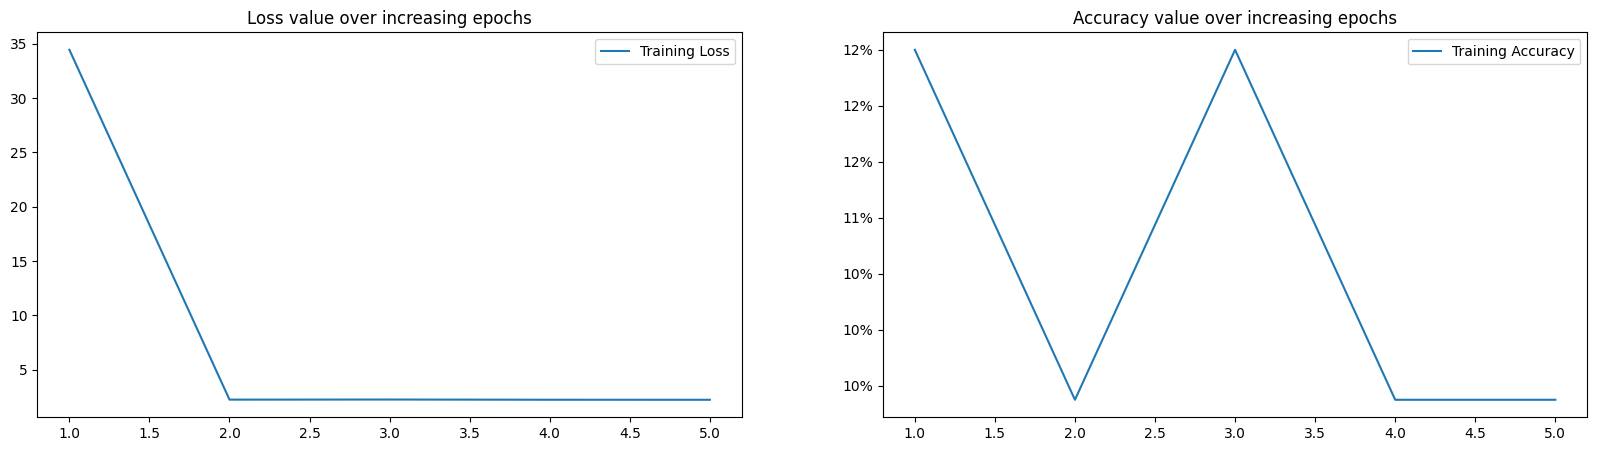

In [29]:
# visualizando losses e accuracy
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()